In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# The following lines make plots in dark mode look reasonable.  If you are not using dark
# mode you don't need them, but you can also just leave them here and it should work fine.

dark_mode = True
# plotting choices for dark-mode
if (dark_mode):
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    linecolor = 'w'
else:
    linecolor = 'k'

In [35]:
# Create a Pandas DataFrame with data for calibration of Torsion pendulum

# The values in this next line are for the WebWork exercise.
calibration_data = [[152.9, 0.05, 9.3, 0.05], [448.5, 0.05, 19.3, 0.05], 
                    [550.5, 0.05, 25.1, 0.05], [560.7, 0.05, 29.8, 0.05], 
                    [825.7, 0.05, 39.1, 0.05]]

# create dataframe
df = pd.DataFrame(calibration_data, columns = ['Mass_mg', 'dMass_mg', 'Theta_Raw', 'dTheta_Raw'])

print('Raw Data - Calibration')
df



Raw Data - Calibration


,Mass_mg,dMass_mg,Theta_Raw,dTheta_Raw
0,152.9,0.05,9.3,0.05
1,448.5,0.05,19.3,0.05
2,550.5,0.05,25.1,0.05
3,560.7,0.05,29.8,0.05
4,825.7,0.05,39.1,0.05


In [36]:
# What is the uncertainty in the mass?  We are not really told in the video.  But, let's
# make an educated guess ... it is probably going to be some absolute finite number, plus
# some percentage error.

#df['dMass_mg'] = 0.1 + df['Mass_mg']*0.01

# Calcualate the actual value of theta by subtracting off the angle for Mass=0.  Also, 
# calculate the error in the actual angle using dTheta = dTheta_Raw[i] + dtheta_Raw[0]

offset = df['Theta_Raw'][0]
doffset = df['dTheta_Raw'][0]

# For WebWork
#offset = 0
#doffset = 0

df['Theta'] = df['Theta_Raw'] - offset
df['dTheta'] = df['dTheta_Raw'] + doffset

# Calculate the mass in kg, and the error in the mass in kg
df['Mass'] = df['Mass_mg']*0.000001
df['dMass'] = df['dMass_mg']*0.000001

# Calculate the gravitational Force (and Error) in Newtons
g = 9.81
df['Force'] = df['Mass']*g
df['dForce'] = df['dMass']*g

# Override the errors in Force and Angle
#df['dTheta'] = 1.0
#df['dForce'] = 1.0

print(df.to_string(index=False))

 Mass_mg  dMass_mg  Theta_Raw  dTheta_Raw  Theta  dTheta      Mass         dMass   Force        dForce
   152.9      0.05        9.3        0.05    0.0     0.1  0.000153  5.000000e-08  0.0015  4.905000e-07
   448.5      0.05       19.3        0.05   10.0     0.1  0.000449  5.000000e-08  0.0044  4.905000e-07
   550.5      0.05       25.1        0.05   15.8     0.1  0.000550  5.000000e-08  0.0054  4.905000e-07
   560.7      0.05       29.8        0.05   20.5     0.1  0.000561  5.000000e-08  0.0055  4.905000e-07
   825.7      0.05       39.1        0.05   29.8     0.1  0.000826  5.000000e-08  0.0081  4.905000e-07


Beta: [0.00020909 0.00179779]
Beta Std Error: [2.28850308e-05 4.16724985e-04]
Beta Covariance: [[ 2.00462321e-07 -3.05103595e-06]
 [-3.05103595e-06  6.64704825e-05]]
Residual Variance: 0.0026125839098113716
Inverse Condition #: 0.029631866732866028
Reason(s) for Halting:
  Sum of squares convergence

Final Result: Y = (0.000209090 +/- 0.000022885) X + (0.001797789 +/- 0.000416725)


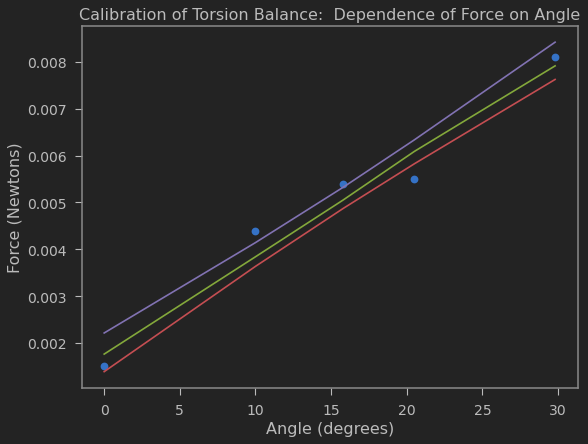

In [37]:
xi = df['Theta']
yi = df['Force']

##############################

def fitfunction(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

linear = Model(fitfunction) # create a Model object based on the fitfuncion we have defined
mydata = RealData(xi, yi, sy=min(1/np.var(yi), 1/np.var(xi))) # create a data object based on our data, include errors.
myodr = ODR(mydata, linear, beta0=[1., 2.]) # create a fitting object, based on the data, fit Model, and an intial set of parameters.
myoutput = myodr.run()  # run the fitting process to get optimized parameters!

myoutput.pprint() # print out the result of the fit

# Now assign the important fit results to some more convenient variables.

popt = myoutput.beta # the vector of optimized parameters
pcov = myoutput.cov_beta # the covariance matrix
perr = myoutput.sd_beta # the vector of ERRORS in the optimized parameters

# The following lines generate upper and lower "Confidence Bands" on the fit, for visualization
# purposes.

from scipy.optimize import curve_fit

def fitfunctionc(x,*paramlist):
    return paramlist[0]+paramlist[1]*x

popt2, pcov2 = curve_fit(fitfunctionc,xi,yi,p0=popt)
perr2 = np.sqrt(np.diag(pcov2))

ps = np.random.multivariate_normal(popt2,pcov2,10000)
ysample=np.asarray([fitfunctionc(xi,*pi) for pi in ps])

lower2 = np.percentile(ysample,16.0,axis=0)
upper2 = np.percentile(ysample,84.0,axis=0)
middle2 = (lower+upper)/2.0

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) X + (%0.9f +/- %0.9f)" % (popt[0],perr[0],popt[1],perr[1]))

plt.figure(figsize=(8, 6), dpi=80)

#plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)
plt.plot(xi,yi,'o')

plt.plot(xi,middle2)
plt.plot(xi,lower2)
plt.plot(xi,upper2)

#########################

plt.xlabel('Angle (degrees)')
plt.ylabel('Force (Newtons)')
plt.title('Calibration of Torsion Balance:  Dependence of Force on Angle')
plt.show()

Coefficients (from curve_fit)
[0.00179784 0.00020909]
Covariance Matrix (from curve_fit)
[[ 1.73659790e-07 -7.97109055e-09]
 [-7.97109055e-09  5.23724739e-10]]

Final Result: y = (0.000209087 +/- 0.000022885) x + (0.001797839 +/- 0.000416725)


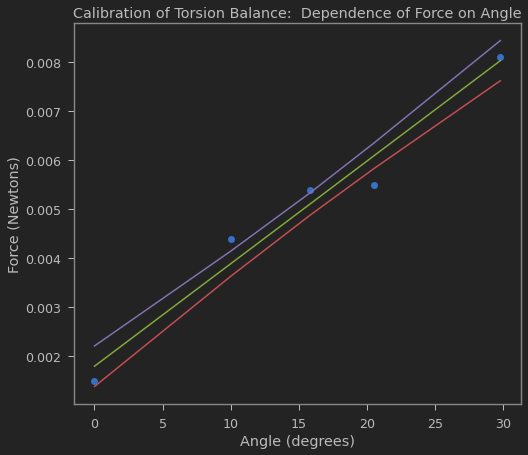

In [38]:
xi = df['Theta']
yi = df['Force']

##############################

from scipy.optimize import curve_fit

def fitfunction(x,*paramlist):
    return paramlist[0]+paramlist[1]*x

init_vals = [0.0 for x in range(2)]
popt2, pcov2 = curve_fit(fitfunction,xi,yi,p0=init_vals)
perr2 = np.sqrt(np.diag(pcov2))

ps = np.random.multivariate_normal(popt2,pcov2,10000)
ysample=np.asarray([fitfunction(xi,*pi) for pi in ps])

lower = np.percentile(ysample,16.0,axis=0)
upper = np.percentile(ysample,84.0,axis=0)
middle = (lower+upper)/2.0

print("Coefficients (from curve_fit)")
print (popt2)
print("Covariance Matrix (from curve_fit)")
print (pcov2)

print()
print ("Final Result: y = (%0.9f +/- %0.9f) x + (%0.9f +/- %0.9f)" % (popt2[1],perr2[1],popt2[0],perr2[0]))

plt.plot(xi,yi,'o')

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################

plt.xlabel('Angle (degrees)')
plt.ylabel('Force (Newtons)')
plt.title('Calibration of Torsion Balance:  Dependence of Force on Angle')
plt.show()

[[ 2.00462321e-07 -3.05103595e-06]
 [-3.05103595e-06  6.64704825e-05]]
[[ 1.73659790e-07 -7.97109055e-09]
 [-7.97109055e-09  5.23724739e-10]]
1.1543393040364462
126918.73712672004
